# Botnet flow data discretization task

In [52]:
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import pandas as pd
import random
import collections
import string
import time

We use the same way to preprocess the data.

During preprocessing, I only reserve 'Botnet' and  'Normal'netflow but delete 'Background' flow data.

In [ ]:
output = StringIO()
csv_writer = csv.writer(output)
column_name = ['Dateflowstart', 'Durat', 'Prot', 'SrcIPAddr:Port', 'DstIPAddr:Port', 'Flags', 'Tos', 'PacketsBytes', 'Flows', 'Label', 'Labels']
Botnet_data = pd.DataFrame(columns = column_name)
with open('capture20110818.pcap.netflow.labeled', 'rb') as f:
    next(f)
    for index, line in enumerate(f):
        #print(line)
        parser = line.decode("utf-8")
        split_by_space = parser.split('\t')
        #print(parser)
        #print(split_by_space)
        temp1 =  [x for x in split_by_space if x != '->']
        temp2 =  [x for x in temp1 if x != '']
        temp2[-1] = temp2[-1].split('\n')[0]
        #print(temp2)
        if(len(temp2)==1):
            
            #print(line)
            #print(parser)
            split_by_space = parser.split(' ')
            #print(split_by_space)
            temp1 =  [x for x in split_by_space if x != '->']
            temp2 =  [x for x in temp1 if x != '']
            temp2[-1] = temp2[-1].split('\n')[0]
            #print(temp2)
            x=temp2.pop(1)
            temp2[0]=temp2[0]+' '+x
            #print(temp1)
            #print(temp2)
        #print(temp1)
        #temp3 =  [x.split('\n')[0] for x in temp2 if '\n' in x]
        #print(temp2)
        if(temp2[-1]!='Background'):
            #print(temp2[-1])
            csv_writer.writerow(temp2)
    output.seek(0) # we need to get back to the start of the BytesIO
    Botnet_data = read_csv(output)
Botnet_data.to_csv('Botnet_data10.csv', sep='\t')

In [3]:
#Load preprocessed data
data=pd.read_csv('Botnet_data10.csv',sep='\t')
data.shape

(645357, 12)

In [7]:
data.info()
column_name=list(data)
print(column_name)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645357 entries, 0 to 645356
Data columns (total 12 columns):
ID                645357 non-null int64
Dateflowstart     645357 non-null object
Durat             644074 non-null float64
Prot              644074 non-null object
SrcIPAddr:Port    644074 non-null object
DstIPAddr:Port    644074 non-null object
Flags             644074 non-null object
Tos               644074 non-null float64
PacketsBytes      644074 non-null float64
Flows             644074 non-null float64
Label             644074 non-null float64
Labels            644074 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 59.1+ MB
['ID', 'Dateflowstart', 'Durat', 'Prot', 'SrcIPAddr:Port', 'DstIPAddr:Port', 'Flags', 'Tos', 'PacketsBytes', 'Flows', 'Label', 'Labels']


Here we focus on the infected IP: '147.32.84.205' and two features: **Prot** and **Flags**

In [4]:
#Obtain corresponding data according to its source.
#Here we choose 'Prot' and 'Flags' features 
feature=['Prot','Flags']
infected_host='147.32.84.205'
#Selected_Botnet_data = pd.DataFrame()
Selected_Botnet_data_feature=[]
for index, row in data.iterrows():
    #print(index)
    #print (row['SrcIPAddr:Port'], row['DstIPAddr:Port'])
    #print(list(row[feature]))
    #if (infected_host in str(row['SrcIPAddr:Port']) or infected_host in str(row['DstIPAddr:Port'])):
    if (infected_host in str(row['SrcIPAddr:Port'])):
        #Selected_Botnet_data.append(row[feature])
        #for item in feature:
        #print(row)
        Selected_Botnet_data_feature.append(list(row[feature]))
    #if(len(Selected_Botnet_data_feature)>100):
        #break
Selected_Botnet_data = pd.DataFrame(Selected_Botnet_data_feature,columns = feature)
Selected_Botnet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24437 entries, 0 to 24436
Data columns (total 2 columns):
Prot     24437 non-null object
Flags    24437 non-null object
dtypes: object(2)
memory usage: 381.9+ KB


### Visualization of these two feature

ICMP    23739
TCP       359
UDP       339
Name: Prot, dtype: int64


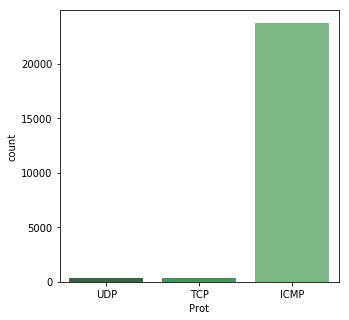

In [64]:
print(Selected_Botnet_data['Prot'].value_counts())
plt.subplots(figsize=(5, 5))
sns.countplot(x="Prot", data=Selected_Botnet_data, palette="Greens_d")

ECO      10466
UNK      10193
ROB        506
INT        339
TST        301
IRQ        300
RTS        300
RTA        300
MAS        299
RA_        225
PA_         87
MRP         58
MRQ         55
SRC         55
NRA         53
WAY         52
PAR         52
AHA         51
PTB         50
DNQ         49
IAH         49
RED         49
TXD         47
DCE         46
TRC         46
MHR         45
SEC         45
NRS         45
NNS         44
SKP         43
NNA         38
DNP         36
PHO         32
UR          30
A_          17
SPA_        16
RPA_         9
SRPA_        4
URISO        1
SA_          1
URCUT        1
URFIL        1
URN          1
Name: Flags, dtype: int64


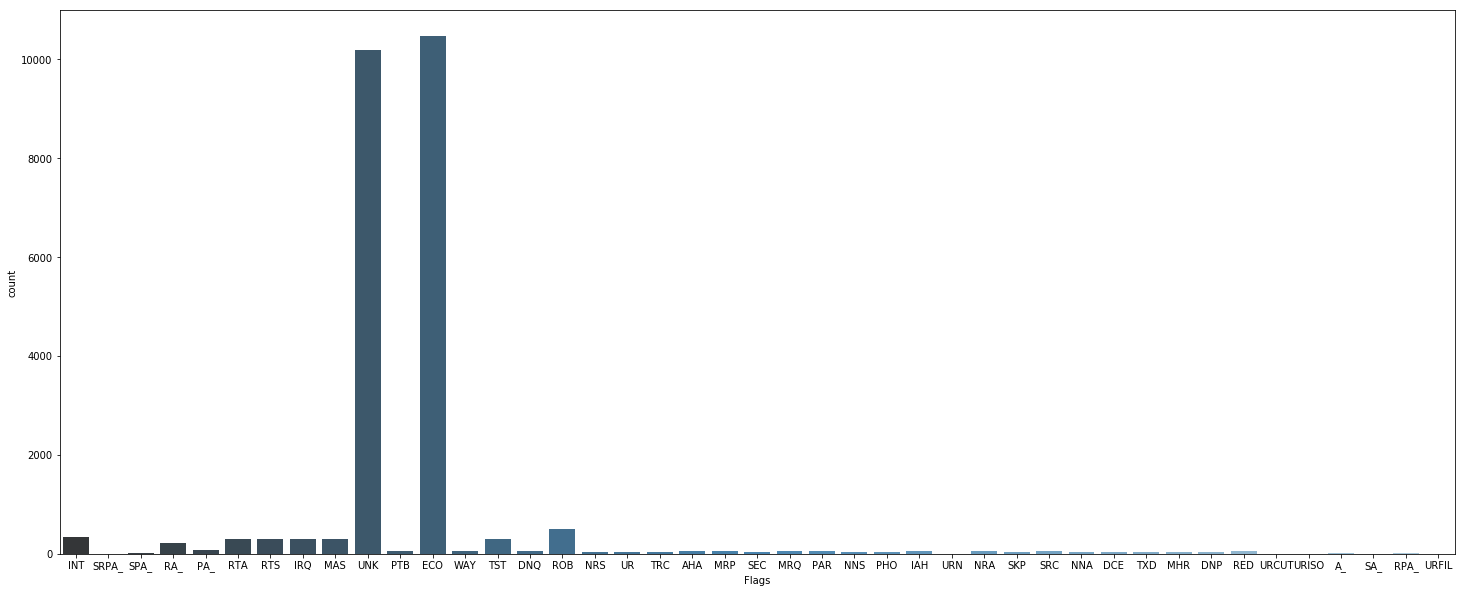

In [5]:
plt.subplots(figsize=(25, 10))
sns.countplot(x="Flags", data=Selected_Botnet_data, palette="Blues_d")
print(Selected_Botnet_data['Flags'].value_counts())

In [74]:
Selected_Botnet_data['Prot'].value_counts()

ICMP    23739
TCP       359
UDP       339
Name: Prot, dtype: int64

In [86]:
e=list(Selected_Botnet_data['Flags'].value_counts().index)
print(len(e),e.index('ECO'))

43 0


In [66]:
Dis_Prot_list=[]
Dis_Flags_list=[]
Combined_Botnet_data=Selected_Botnet_data
Flags_list=list(Selected_Botnet_data['Flags'].value_counts().index)
Prot_list=list(Selected_Botnet_data['Prot'].value_counts().index)
print(Flags_list,len(Flags_list))
print(Prot_list)
for index, row in Combined_Botnet_data.iterrows():
    Dis_Prot_list.append(Prot_list.index(row['Prot']))
    Dis_Flags_list.append(Flags_list.index(row['Flags']))
#print(Dis_Flags_list)
Combined_Botnet_data['Dis_Prot']=Dis_Prot_list
Combined_Botnet_data['Dis_Flags']=Dis_Flags_list

['ECO', 'UNK', 'ROB', 'INT', 'TST', 'IRQ', 'RTS', 'RTA', 'MAS', 'RA_', 'PA_', 'MRP', 'MRQ', 'SRC', 'NRA', 'WAY', 'PAR', 'AHA', 'PTB', 'DNQ', 'IAH', 'RED', 'TXD', 'DCE', 'TRC', 'MHR', 'SEC', 'NRS', 'NNS', 'SKP', 'NNA', 'DNP', 'PHO', 'UR', 'A_', 'SPA_', 'RPA_', 'SRPA_', 'URISO', 'SA_', 'URCUT', 'URFIL', 'URN'] 43
['ICMP', 'TCP', 'UDP']


In [67]:
Combine_feature_list=[]
for index, row in Combined_Botnet_data.iterrows():
    Combine_feature_list.append(row['Dis_Prot']*len(Flags_list)+row['Dis_Flags'])
    #print(row['Dis_Prot']*len(Prot_list)+row['Dis_Flags'])
Combined_Botnet_data['Combine']=Combine_feature_list

Do the discretization of the whole dataset.

In [69]:
data=pd.read_csv('Botnet_data10.csv',sep='\t')
Dis_Prot_list=[]
Dis_Flags_list=[]
Label_list=[]
Flags_list=list(data['Flags'].value_counts().index)
Prot_list=list(data['Prot'].value_counts().index)
print(Flags_list,len(Flags_list))
print(Prot_list)
for index, row in data.iterrows():
    #print(row['Prot'])
    #if(row['Prot']=='nan'):
    #print (index)
    if(row['Labels']=='Botnet'):
        Label_list.append(70)
    else:
        Label_list.append(0)
    Dis_Prot_list.append(Prot_list.index(row['Prot']))
    Dis_Flags_list.append(Flags_list.index(row['Flags']))
#print(Dis_Flags_list)
data['Dis_Prot']=Dis_Prot_list
data['Dis_Flags']=Dis_Flags_list
data['Int_label']=Label_list
Combine_feature_list=[]
for index, row in data.iterrows():
    Combine_feature_list.append(row['Dis_Prot']*len(Flags_list)+row['Dis_Flags'])    
data['Combine']=Combine_feature_list


Dis_Prot_list=[]
Dis_Flags_list=[]
#print(Flags_list,len(Flags_list))
#print(Prot_list)
for index, row in Selected_Botnet_data.iterrows():
    Dis_Prot_list.append(Prot_list.index(row['Prot']))
    Dis_Flags_list.append(Flags_list.index(row['Flags']))
#print(Dis_Flags_list)
Selected_Botnet_data['Dis_Prot']=Dis_Prot_list
Selected_Botnet_data['Dis_Flags']=Dis_Flags_list
Combine_feature_list=[]
for index, row in Selected_Botnet_data.iterrows():
    Combine_feature_list.append(row['Dis_Prot']*len(Flags_list)+row['Dis_Flags'])
    #print(row['Dis_Prot']*len(Prot_list)+row['Dis_Flags'])
Selected_Botnet_data['Combine']=Combine_feature_list


['ECO', 'ECR', 'UNK', 'A_', 'PA_', 'SPA_', 'FA_', '_FSPA', 'FSPA_', 'INT', 'FPA_', 'SA_', 'RA_', 'ROB', 'S_', 'RTA', 'TSR', 'TST', 'MSR', 'MAS', 'IRQ', 'RTS', 'IRR', 'FSA_', '_FSA', '___', 'FSRPA_', 'SRPA_', 'FRA_', 'FRPA_', 'IAH', 'WAY', 'SKP', 'MRQ', 'NRA', 'SRC', 'RED', 'NNA', 'SEC', 'PHO', 'PAR', 'MRP', 'AHA', 'PTB', 'TRC', 'NNS', 'MHR', 'UR', 'DCE', 'DNP', 'NRS', 'TXD', 'DNQ', 'R_', 'URH', '_FSRPA', 'RPA_', 'URP', 'SR_', 'PAC_', 'SRA_', '_FSRA', 'URHPRO', 'SPAC_', 'FSPAEC_', 'URNU', 'SEC_', 'URISO', 'URHU', 'FSPAC_', 'URHTOS', 'URNPRO', 'URPRE', 'URCUT', 'FSRA_', 'URS', 'URFIL', 'URN'] 78
['TCP', 'ICMP', 'UDP']


Text(0.5,1,'Counts of combined feature of the whole dataset')

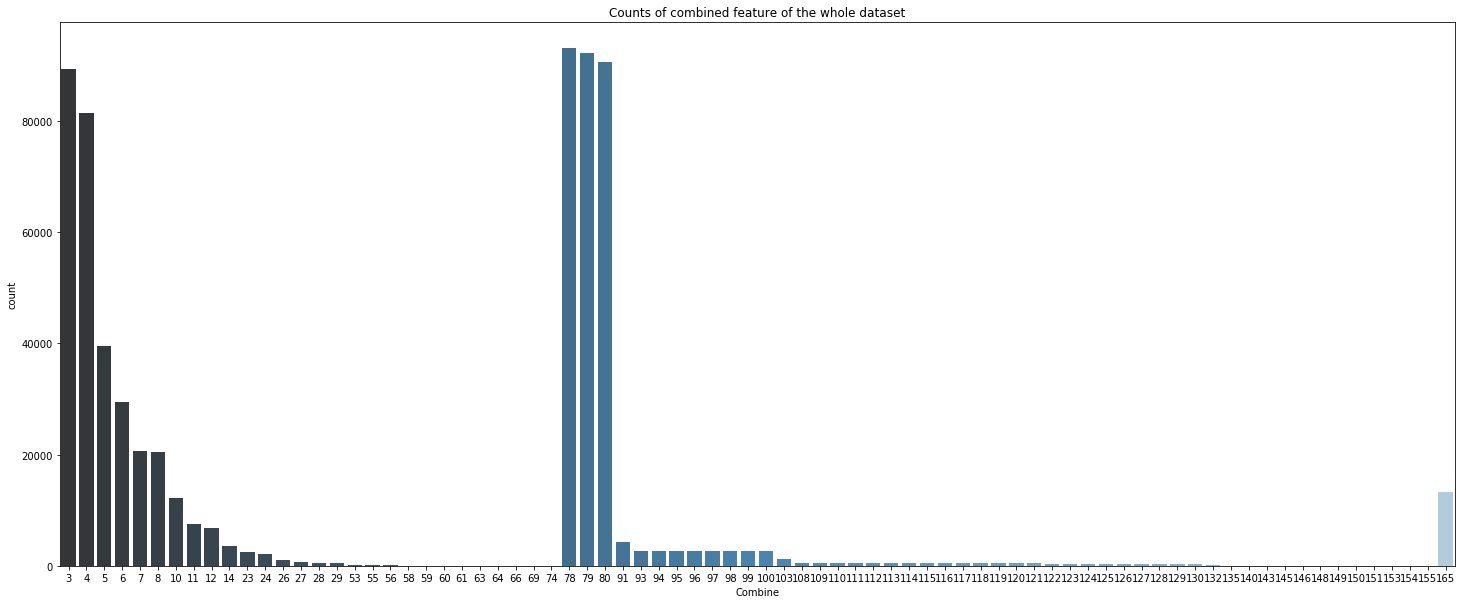

In [94]:
plt.subplots(figsize=(25, 10))
sns.countplot(x="Combine", data=data, palette="Blues_d").set_title('Counts of combined feature of the whole dataset')

Text(0.5,1,'Counts of combined feature of seleted Botnet data')

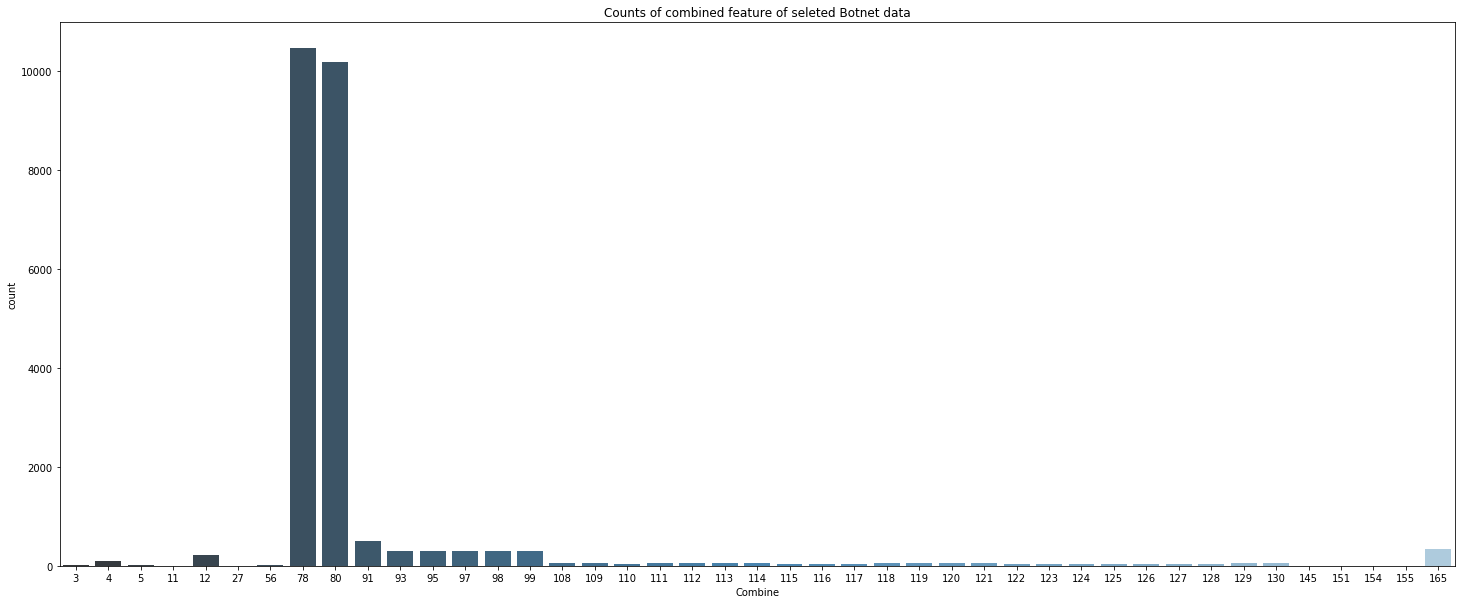

In [96]:
#print(Selected_Botnet_data['Combine'].value_counts())
plt.subplots(figsize=(25, 10))
sns.countplot(x="Combine", data=Combined_Botnet_data, palette="Blues_d").set_title('Counts of combined feature of seleted Botnet data')

Here we first choose the combined feature '78' and '80' to test

In [93]:
tp=0
tn=0
fp=0
fn=0
label=[78,80]
for index, row in data.iterrows():
    #print(row['Combine'],row['Int_label'],row['Labels'])
    if (infected_host not in str(row['SrcIPAddr:Port'])):
    #if(True):
        if ((row['Combine'] in label)and row['Int_label']==70):
            tp+=1
        else: 
            if ((row['Combine'] in label)and row['Int_label']==0):
                fp+=1
            else:  
                if ((row['Combine'] not in label)and row['Int_label']==0):
                    tn+=1
                else:
                    fn+=1
print('tp=',tp,'tn=',tn,'fp=',fp,'fn=',fn)
print('recall=',tp/(tp+fn),' precision=',tp/(tp+fp))
print('tpr=',tp/(tp+fn),' fpr=',fp/(fp+tn))

tp= 162256 tn= 321157 fp= 787 fn= 136585
recall= 0.5429509337741475  precision= 0.9951730525076207
tpr= 0.5429509337741475  fpr= 0.0024445245135800014


Text(0.5,1,'Counts of combined feature of normal data')

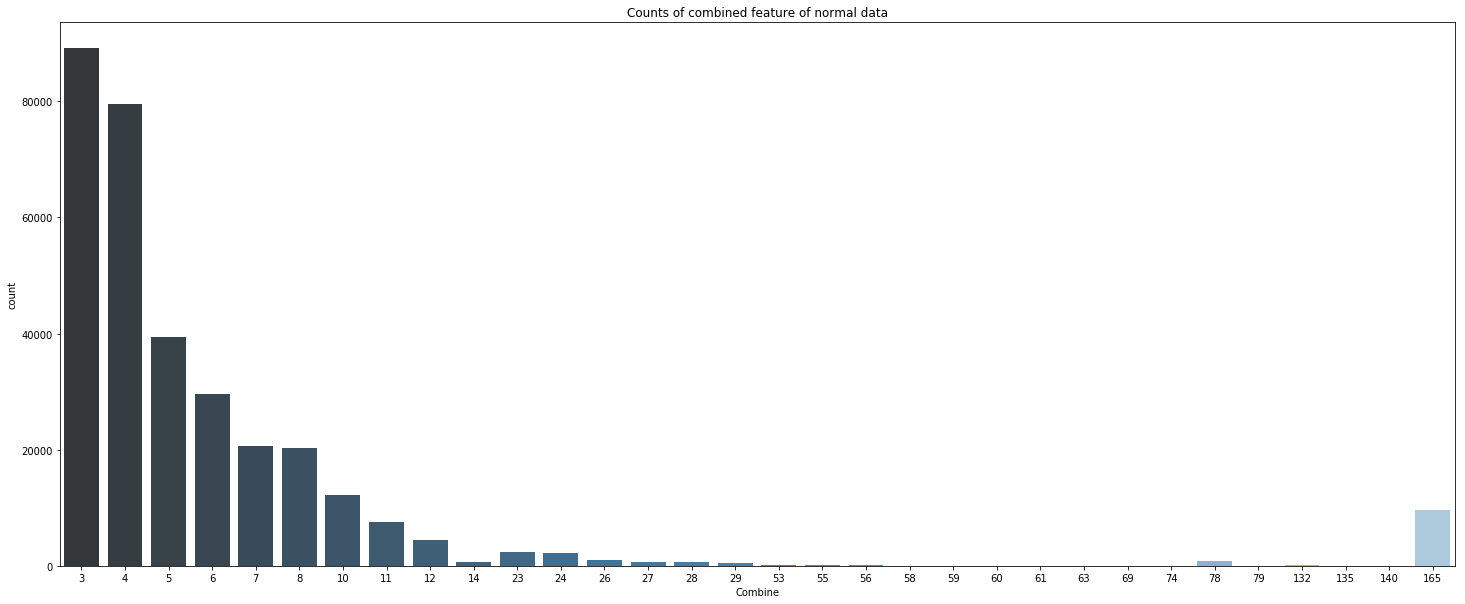

In [98]:
plt.subplots(figsize=(25, 10))
sns.countplot(x="Combine", data=data[data['Labels']!='Botnet'], palette="Blues_d").set_title('Counts of combined feature of normal data')

Text(0.5,1,'Counts of combined feature of Botnet data')

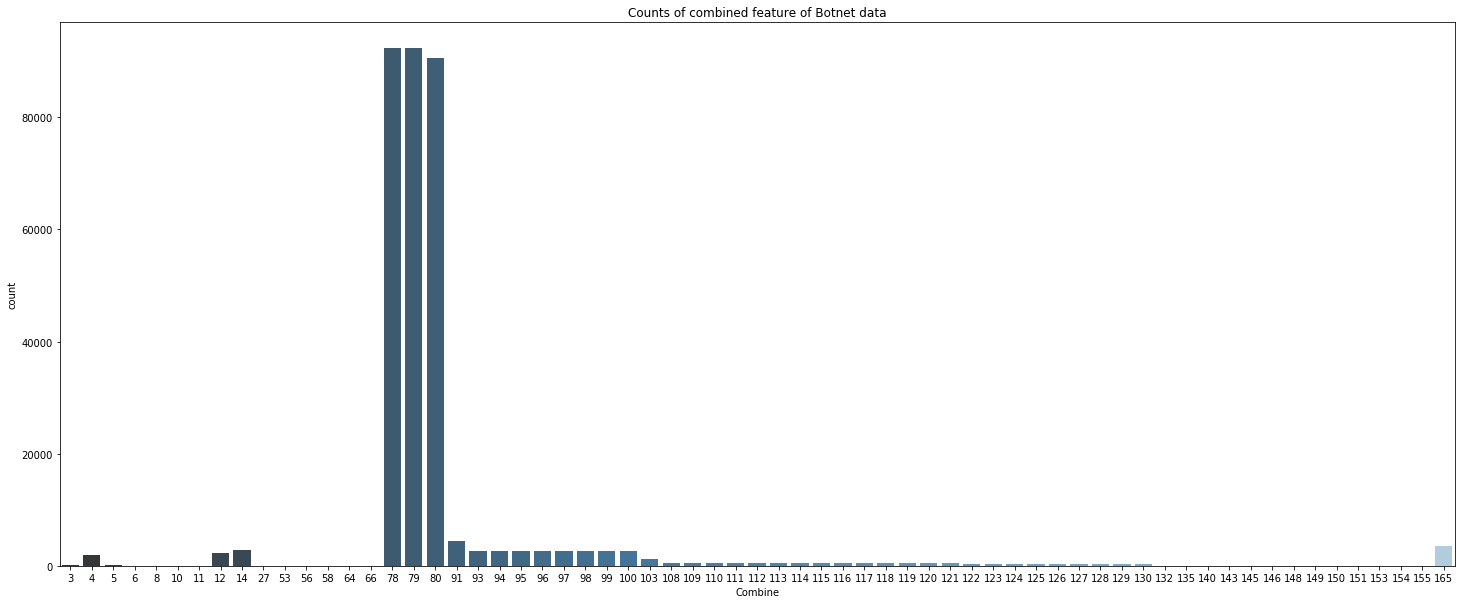

In [95]:
plt.subplots(figsize=(25, 10))
sns.countplot(x="Combine", data=data[data['Labels']=='Botnet'], palette="Blues_d").set_title('Counts of combined feature of Botnet data')

Here we first choose the combined feature '78','79' and '80' to test

In [97]:
tp=0
tn=0
fp=0
fn=0
label=[78,79,80]
for index, row in data.iterrows():
    #print(row['Combine'],row['Int_label'],row['Labels'])
    if (infected_host not in str(row['SrcIPAddr:Port'])):
    #if(True):
        if ((row['Combine'] in label)and row['Int_label']==70):
            tp+=1
        else: 
            if ((row['Combine'] in label)and row['Int_label']==0):
                fp+=1
            else:  
                if ((row['Combine'] not in label)and row['Int_label']==0):
                    tn+=1
                else:
                    fn+=1
print('tp=',tp,'tn=',tn,'fp=',fp,'fn=',fn)
print('recall=',tp/(tp+fn),' precision=',tp/(tp+fp))
print('tpr=',tp/(tp+fn),' fpr=',fp/(fp+tn))

tp= 254512 tn= 321151 fp= 793 fn= 44329
recall= 0.8516635936835977  precision= 0.9968939112042459
tpr= 0.8516635936835977  fpr= 0.0024631612951320726


In [141]:
from sklearn.cross_validation import train_test_split
data_train, data_test, label_train, label_test = train_test_split(data[['Dis_Flags','Dis_Prot']], data['Int_label'], test_size = 0.3)#test_size: proportion of train/test data

In [145]:
from collections import Counter
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
clf=LogisticRegression(C=10)
#clf=tree.DecisionTreeClassifier()
clf.fit(data_train,label_train)
predict_label=clf.predict(data_test)
print(Counter(predict_label-label_test))
tn, fp, fn, tp = confusion_matrix(label_test, predict_label).ravel()
print('tp=',tp,' fp=',fp,' fn=',fn,' tn=',tn)

Counter({0: 188110, 70: 3196, -70: 2302})
tp= 94761  fp= 3196  fn= 2302  tn= 93349
